### 使用 RNN 进行气温的时间序列预测

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. 读取数据
df = pd.read_csv('./data/daily-min-temperatures.csv')
temps = df['Temp'].values.astype(np.float32).reshape(-1, 1)

# 2. 归一化（0~1）
scaler = MinMaxScaler()
temps_norm = scaler.fit_transform(temps)
print(temps_norm)


e:\Anaconda\envs\project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[0.7870723 ]
 [0.6806084 ]
 [0.7148289 ]
 ...
 [0.51330805]
 [0.5969582 ]
 [0.4942966 ]]


In [3]:
# 3. 创建滑动窗口序列数据集
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30  # 用过去30天预测第31天
X, y = create_sequences(temps_norm, window_size)

# 4. 划分训练/测试集（80%训练，20%测试）
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# 5. 转为 PyTorch tensor 和 DataLoader
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

print(X_train_t.shape, y_train_t.shape)


torch.Size([2896, 30, 1]) torch.Size([2896, 1])


In [4]:
batch_size = 64
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# 定义简单的RNN网络
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNNCell(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        for t in range(seq_len):
            h = self.rnn(x[:, t, :], h)
        out = self.fc(h)
        return out

In [6]:
# 7. 初始化模型和训练配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN(input_dim=1, hidden_dim=64, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 8. 训练模型
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.6f}")

# 9. 测试预测
model.eval()
with torch.no_grad():
    X_test_t = X_test_t.to(device)
    preds = model(X_test_t).cpu().numpy()
    y_true = y_test_t.numpy()


Epoch 1/30 Train Loss: 0.050705
Epoch 2/30 Train Loss: 0.017302
Epoch 3/30 Train Loss: 0.012660
Epoch 4/30 Train Loss: 0.011144
Epoch 5/30 Train Loss: 0.010748
Epoch 6/30 Train Loss: 0.010680
Epoch 7/30 Train Loss: 0.010858
Epoch 8/30 Train Loss: 0.009772
Epoch 9/30 Train Loss: 0.009661
Epoch 10/30 Train Loss: 0.009348
Epoch 11/30 Train Loss: 0.009270
Epoch 12/30 Train Loss: 0.009354
Epoch 13/30 Train Loss: 0.009203
Epoch 14/30 Train Loss: 0.009130
Epoch 15/30 Train Loss: 0.009010
Epoch 16/30 Train Loss: 0.008912
Epoch 17/30 Train Loss: 0.009003
Epoch 18/30 Train Loss: 0.008851
Epoch 19/30 Train Loss: 0.008774
Epoch 20/30 Train Loss: 0.008803
Epoch 21/30 Train Loss: 0.008921
Epoch 22/30 Train Loss: 0.008911
Epoch 23/30 Train Loss: 0.008860
Epoch 24/30 Train Loss: 0.008872
Epoch 25/30 Train Loss: 0.008957
Epoch 26/30 Train Loss: 0.008941
Epoch 27/30 Train Loss: 0.008843
Epoch 28/30 Train Loss: 0.008883
Epoch 29/30 Train Loss: 0.008887
Epoch 30/30 Train Loss: 0.008894


Test MSE: 4.8318
Test RMSE: 2.1981
Test MAE: 1.7338
Test R2: 0.7125


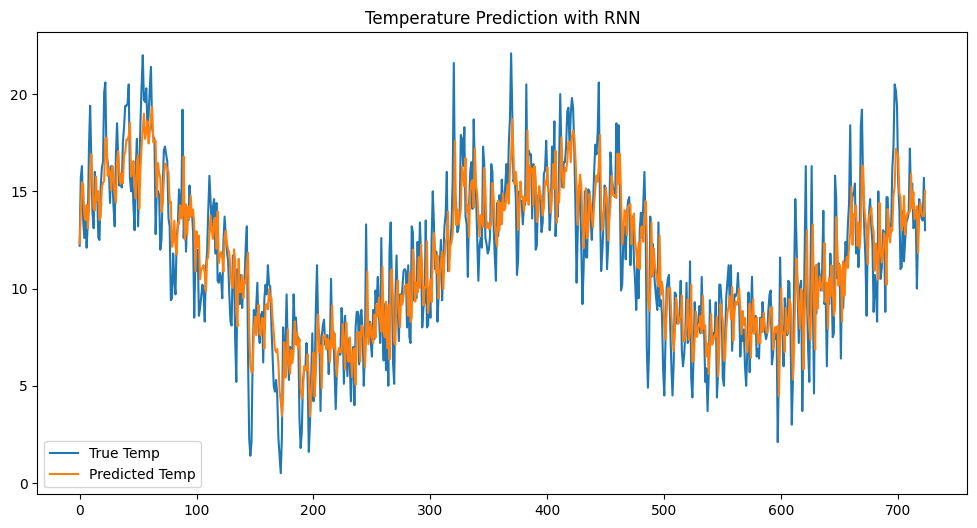

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 10. 反归一化
preds_inv = scaler.inverse_transform(preds)
y_true_inv = scaler.inverse_transform(y_true)

mse = mean_squared_error(y_true_inv, preds_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inv, preds_inv)
r2 = r2_score(y_true_inv, preds_inv)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

# 11. 画图对比
plt.figure(figsize=(12,6))
plt.plot(y_true_inv, label='True Temp')
plt.plot(preds_inv, label='Predicted Temp')
plt.legend()
plt.title("Temperature Prediction with RNN")
plt.show()